In [17]:
import zipfile
import pytesseract
import cv2 as cv
import numpy as np
import tqdm
from PIL import Image, ImageDraw, ImageFont
from zipfile import ZipFile 
from termcolor import colored

In [18]:
file = r'c:\Users\massimiliano.canosi\Downloads\images.zip'

small_file = r'c:\Users\massimiliano.canosi\Downloads\small_img.zip'

In [19]:
face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_eye.xml')

## Folder Info

In [20]:
def folderInfo(file):

    """
    This function generates insights about the selected folder and prints them.
    """

    with ZipFile(file, mode = 'r') as opener:
        
        name_lst = opener.namelist()
        file_info = opener.infolist()
        for i in range(len(name_lst)):
            print(colored(f"-- File {i} info", color='yellow', attrs=['bold']))
            print("Name: " + colored(f"{name_lst[i]}", color='green', attrs=['underline']))
            print(file_info[i])
            print(colored("Image retrieved correctly!\n", color='green', attrs=['underline']))

In [21]:
pytesseract.pytesseract.tesseract_cmd = r'c:\Users\massimiliano.canosi\AppData\Local\Tesseract-OCR\tesseract.exe'

In [22]:
ref_dict = {}

## Text Recognition

In [23]:
def textRecognition(file):

    
    """ 
    This function scans all images to extract the text contained within them.
    """
    
    global ref_dict


    with ZipFile(file, mode = 'r') as reader:
        name_lst = reader.namelist()
        file_info = reader.infolist()
        for i,v in enumerate(name_lst):

            ifile = reader.open(name_lst[i])
            text = pytesseract.image_to_string(Image.open(ifile))
            
            ref_dict[v] = {}
            ref_dict[v]['text'] = text.lower()
            
    return ref_dict

In [24]:
textRecognition(file)

{'a-0.png': {'text': "ann arbor, michigan\n\nwednesday, november 5, 2014\n\nche michigan daily\n\nmichigandaily.com\n\nbig day for republicans\n\nsnyder earns second term; g.o.p. takes control of u.s. senate\n\nstate\n\nexecutive\ngovernor\nrick snyder (r)\n\nlieutenant\ngovernor\nbrian calley (r)\n\nsecretary of\nstate\nruth johnson (r)\n\nstate\njudicial\n\nattorney general\nbill schuette cr)\n\nmichigan\nlegislative\n\nmichigan state\nsenate\nrebekah warren (d)\n\nmichigan house\nof representatives\njeff irwin cd)\n\nu.s.\nlegislative\n\nu.s. senate\ngary peters (d)\n\nu.s. house of\nrepresentatives\ndebbie dingell (d)\n\nwashtenaw\ncounty\n\nprobate court\njulia owdziej (d)\n\ncircuit court\npatrick conlin (d)\n\nann arbor\nmayor\nchristopher taylor (d)\n\ncity council\n\nsumi kailasapathy (d)\nchuck warpehoski (d)\njulie grand (d)\ngraydon kraphol (d)\nkirk westphal (d)\n\nregents\n\ntoo close to call\n\nhi: 51\nlo: 30\n\nweather\ntomorrow\n\ntop: republican gov. rick snyder celeb

Debugging

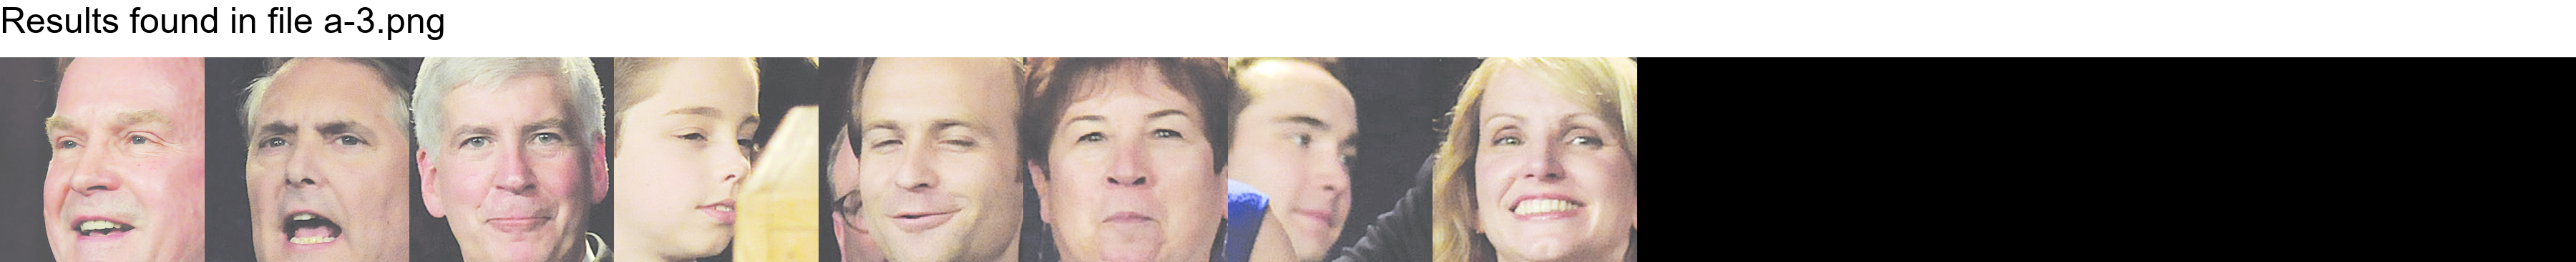

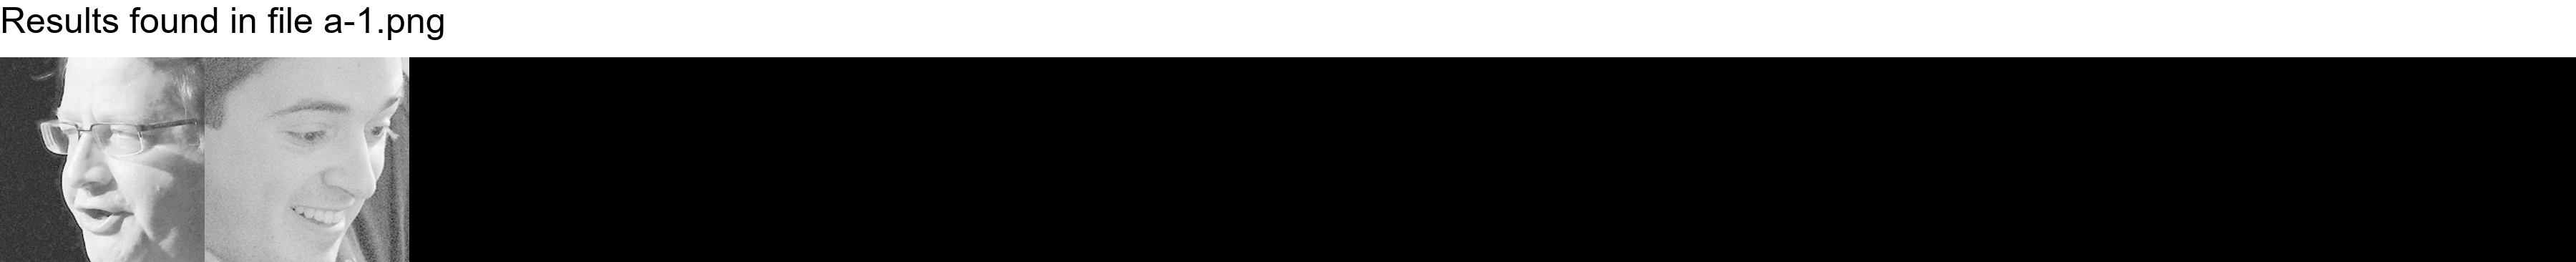

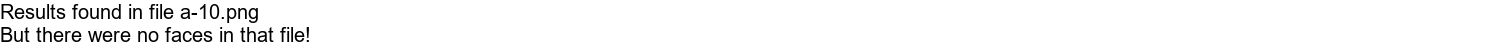

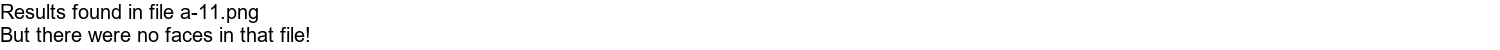

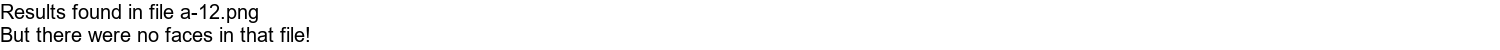

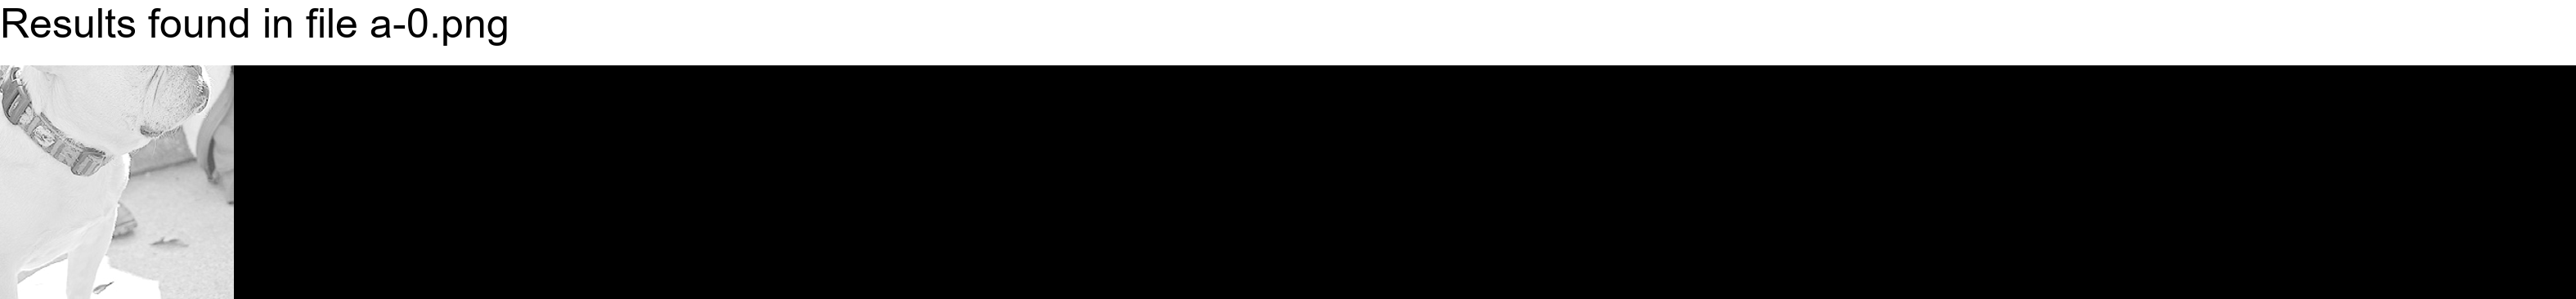

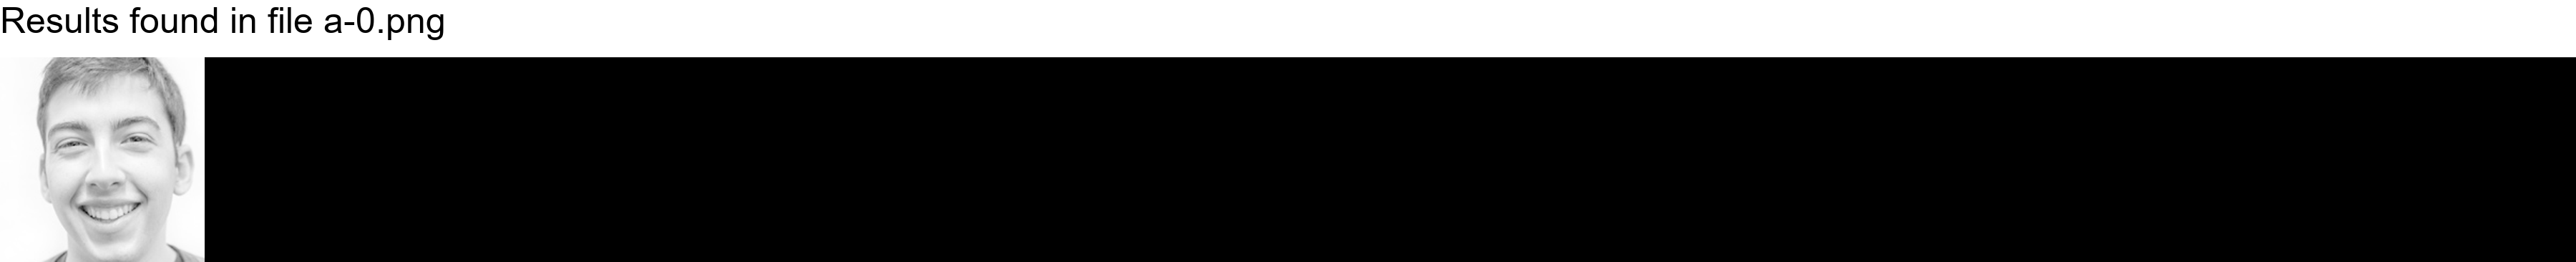

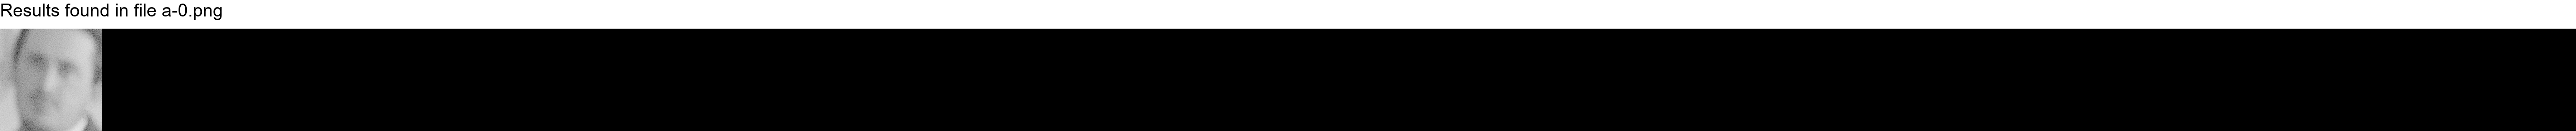

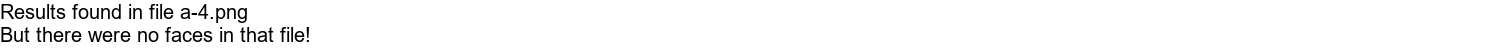

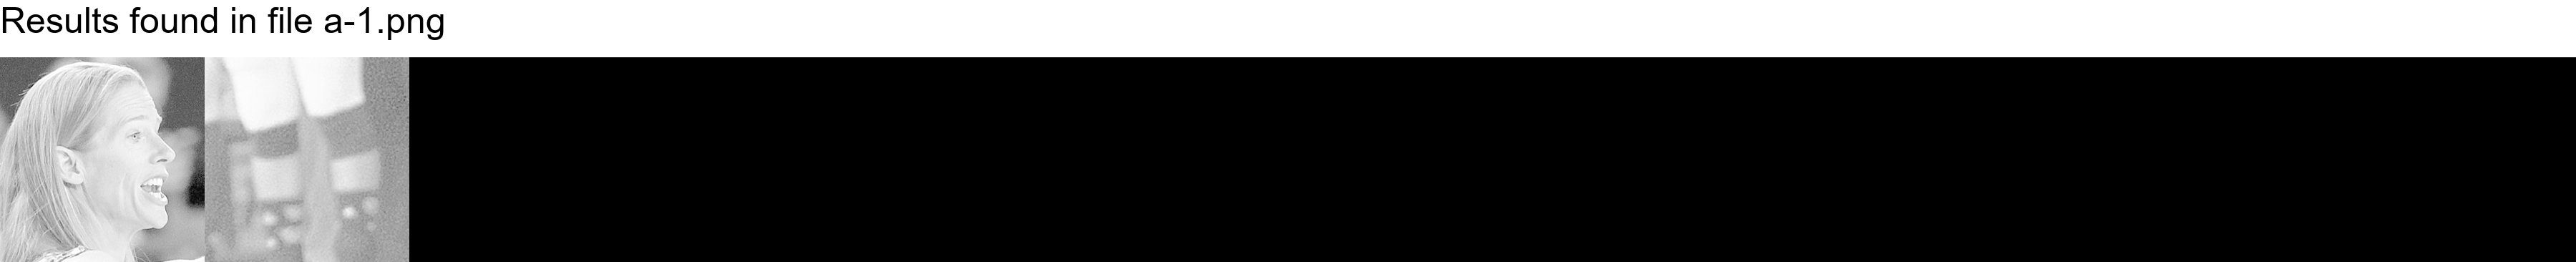

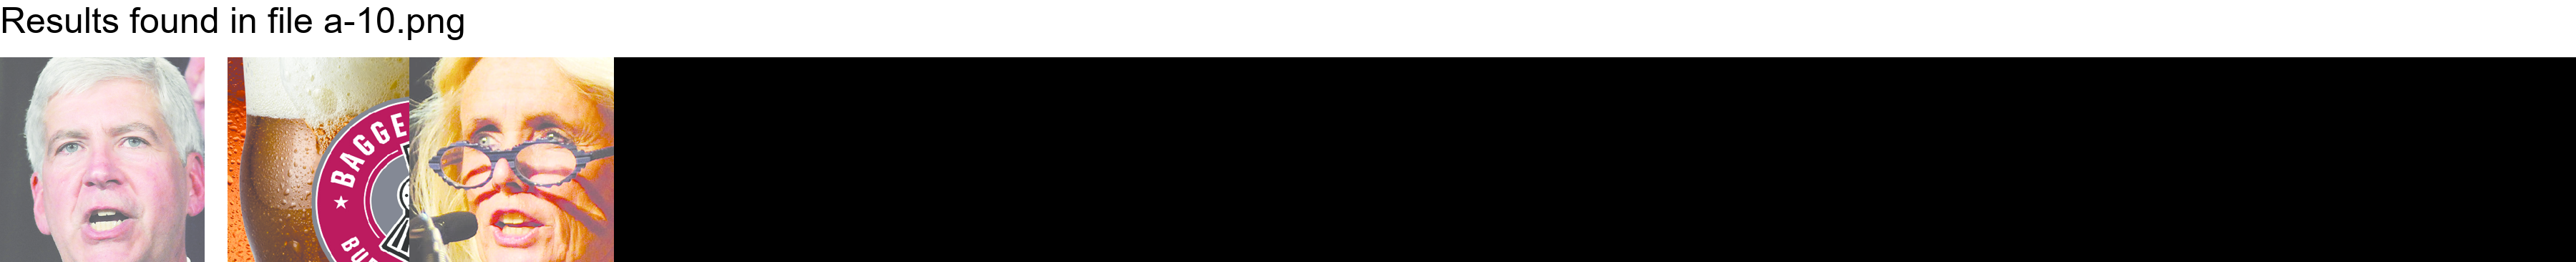

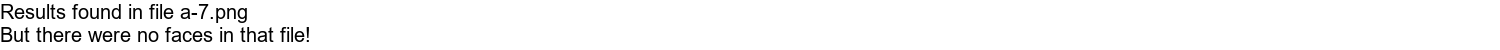

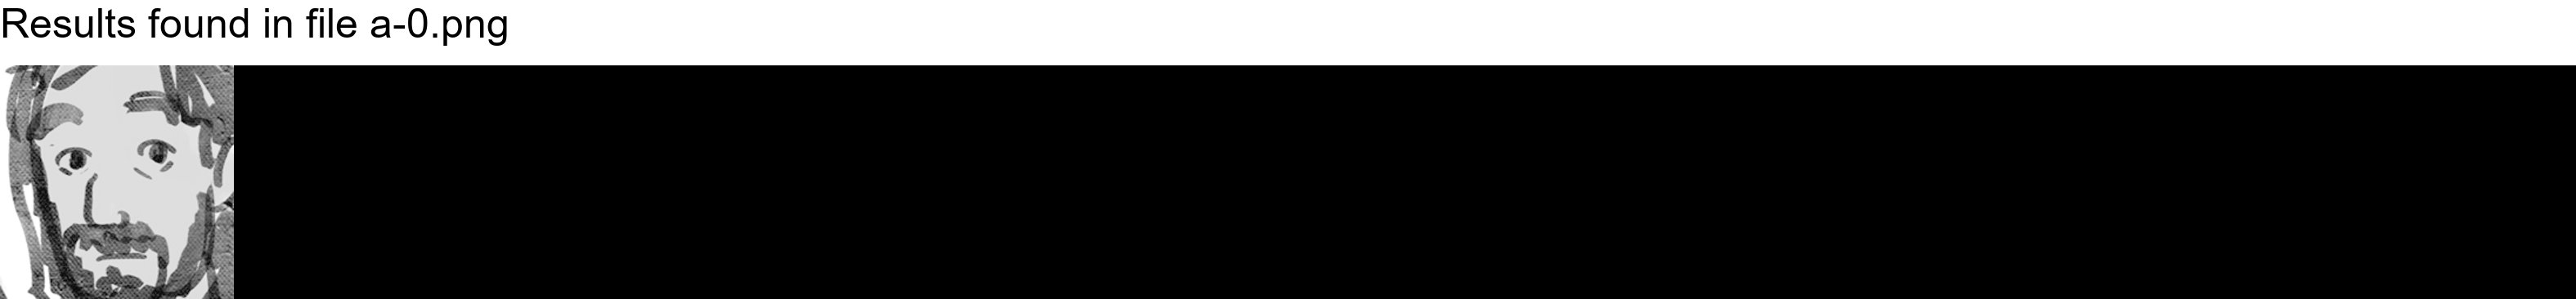

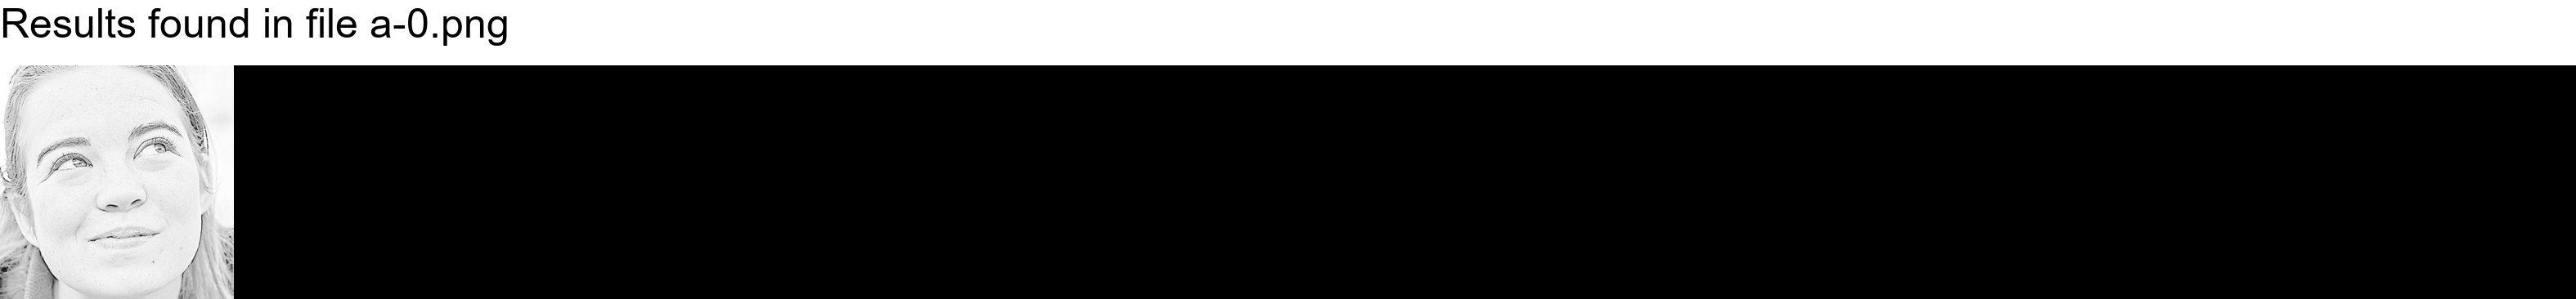

In [87]:
with ZipFile(file, mode = 'r') as reader:
    name_lst = reader.namelist()
    file_info = reader.infolist()
    for i,v in enumerate(name_lst):

        ifile = reader.open(name_lst[i])

        img = Image.open(ifile)

        np_image = np.array(img)

        cv_img_binarization = cv.threshold(np_image, 180,181,cv.THRESH_BINARY)[1]

        faces  = face_cascade.detectMultiScale(cv_img_binarization, minSize=[165,165], minNeighbors=5)  

        # openCV IMAGE COORDINATES ARE (X,Y,W,H)
        try:
            if isinstance(faces, np.ndarray):

                banner = Image.new('RGB', (img.width, 80), color='white')
                background = Image.new('RGB', (img.width, 286 + banner.height))


                new_img = background.copy()
                new_img.paste(banner, (0,0))
                font = ImageFont.truetype('c:\windows\Fonts\ARIAL.TTF', 50)

                faces_lst = faces.tolist()
                faces_lst.sort(key = lambda x: x[3], reverse=True)

                W_img_to_paste = 0
                Y_img_to_paste = 0 + banner.height

                for i, face_coord in enumerate(faces_lst):

                # PIL IMAGE COORDINATES ARE (x1,y1,x2,y2)
                # In order to find x2 you have to sum the starting point "X" and the total width of the rectangle "W"

                    x,y,w,h = face_coord

                    face_region = Image.fromarray(np_image[y:y+h, x:x+w])

                # Get std image size and resize every other image.
                    
                    face_region = face_region.resize((286, 286))

                # Paste image to banner+background template.

                    new_img.paste(face_region,(0+W_img_to_paste, Y_img_to_paste))
                    W_img_to_paste += face_region.width   
                    text = f"Results found in file {name_lst[i]}" 


            else:

                banner = Image.new('RGB', (1500,50), color='white')
                new_img = banner.copy()
                new_img.paste(banner, (0,0))
                font = ImageFont.truetype('c:\windows\Fonts\ARIAL.TTF', 20)
                text = f"Results found in file {name_lst[i]}\nBut there were no faces in that file!"


            # Write text in banner
            draw = ImageDraw.Draw(new_img)
            draw.text((0, 0), text, font=font, fill=(0,0,0,255))


            display(new_img)

        ####
            
            ref_dict[v]['imgs'] = new_img

        ####

        except Exception as e:
            print(f"Error processing {name_lst[i]}: {e}")
            continue

## empty should be 8,10

## Manual Tresholding

In [328]:
def manualTresh(file):    

    """ 
    For every pixel, the same threshold value is applied. 
    If the pixel value is smaller than the threshold, it is set to 0, otherwise it is set to a maximum value. 
    The function cv.threshold is used to apply the thresholding.

    For each image, this function prints a banner and indicates whether faces were found in the image.
    """
    
    global ref_dict

    with ZipFile(file, mode = 'r') as reader:
        name_lst = reader.namelist()
        file_info = reader.infolist()
        for i,v in enumerate(name_lst):

            ifile = reader.open(name_lst[i])


            img = Image.open(ifile)
            banner = Image.new('RGB', (img.width, 80), color='white')
            background = Image.new('RGB', (img.width, 350 + banner.height))
            new_img = background.copy()
            new_img.paste(banner, (0,0))
            font = ImageFont.truetype('c:\windows\Fonts\ARIAL.TTF', 50)

            np_image = np.array(img)

            cv_img_binarization = cv.threshold(np_image, 180,181,cv.THRESH_BINARY)[1]

            faces  = face_cascade.detectMultiScale(cv_img_binarization)

            # openCV IMAGE COORDINATES ARE (X,Y,W,H)
            
            ######## text = f"Results found in file {name_lst[i]}\nBut there were no faces in that file!"
            
            try:
                if isinstance(faces, np.ndarray):

                    faces_lst = faces.tolist()
                    faces_lst.sort(key = lambda x: x[3], reverse=True)

                    W_img_to_paste = 0
                    Y_img_to_paste = 0 + banner.height

                    for face_coord in faces_lst:
                        # PIL IMAGE COORDINATES ARE (x1,y1,x2,y2)
                        # In order to find x2 you have to sum the starting point "x1" and the total widht of the rectangle "W"
                        x,y,w,h = face_coord
                        face_region = Image.fromarray(np_image[y:y+h, x:x+w])
                        new_img.paste(face_region,(0+W_img_to_paste, Y_img_to_paste))
                        W_img_to_paste += face_region.width   
                        text = f"Results found in file {name_lst[i]}" 


                    draw = ImageDraw.Draw(new_img)
                    draw.text((0, 0), text, font=font, fill=(0,0,0,255))

            ##############################################################################
                
                    ref_dict[v]['imgs'] = new_img
            except Exception as e:
                print(f"Error processing {name_lst[i]}: {e}")
                continue
    return ref_dict

            

In [329]:
manualTresh(file)

{'a-0.png': {'text': "ann arbor, michigan\n\nwednesday, november 5, 2014\n\nche michigan daily\n\nmichigandaily.com\n\nbig day for republicans\n\nsnyder earns second term; g.o.p. takes control of u.s. senate\n\nstate\n\nexecutive\ngovernor\nrick snyder (r)\n\nlieutenant\ngovernor\nbrian calley (r)\n\nsecretary of\nstate\nruth johnson (r)\n\nstate\njudicial\n\nattorney general\nbill schuette cr)\n\nmichigan\nlegislative\n\nmichigan state\nsenate\nrebekah warren (d)\n\nmichigan house\nof representatives\njeff irwin cd)\n\nu.s.\nlegislative\n\nu.s. senate\ngary peters (d)\n\nu.s. house of\nrepresentatives\ndebbie dingell (d)\n\nwashtenaw\ncounty\n\nprobate court\njulia owdziej (d)\n\ncircuit court\npatrick conlin (d)\n\nann arbor\nmayor\nchristopher taylor (d)\n\ncity council\n\nsumi kailasapathy (d)\nchuck warpehoski (d)\njulie grand (d)\ngraydon kraphol (d)\nkirk westphal (d)\n\nregents\n\ntoo close to call\n\nhi: 51\nlo: 30\n\nweather\ntomorrow\n\ntop: republican gov. rick snyder celeb

## Run Functions

try

In [265]:
usr_input = 'Mark'

textRecognition(file)
manualTresh(file)

print(ref_dict)

for k,v in ref_dict.items():
    if usr_input.lower() in v['text']:
        display(v['imgs'])

AttributeError: 'tuple' object has no attribute 'tolist'

In [245]:
usr_input = 'Mark'

textRecognition(file)
manualTresh(file)

print(ref_dict)

for k,v in ref_dict.items():
    if usr_input.lower() in v['text']:
        display(v['imgs'])

AttributeError: 'tuple' object has no attribute 'tolist'

first try

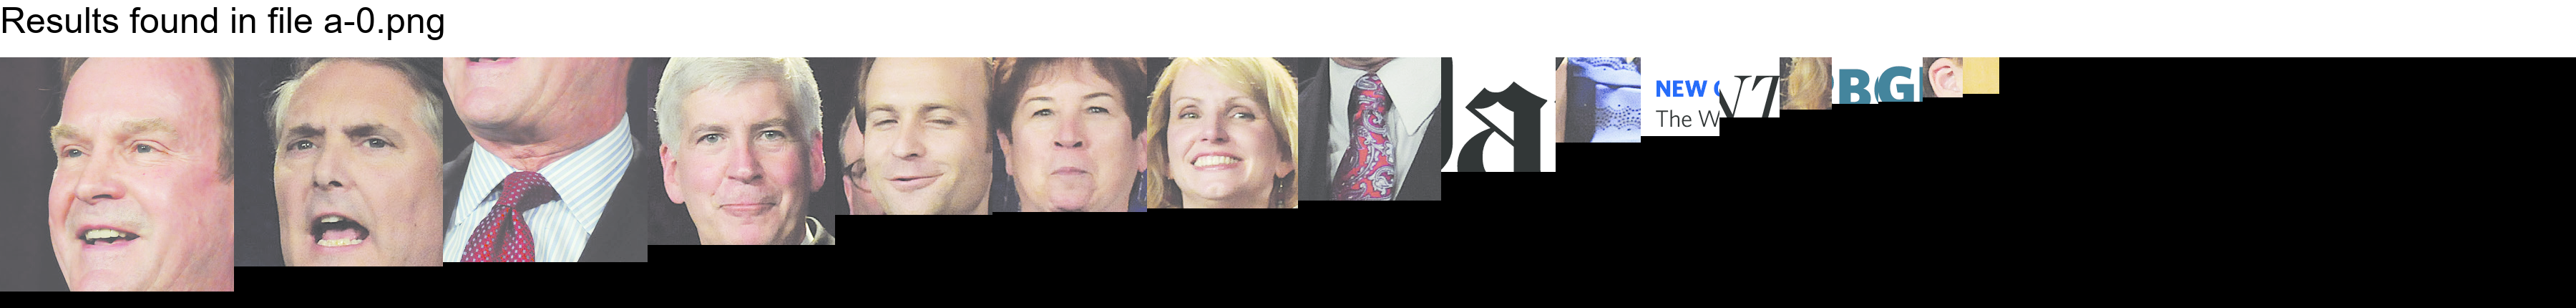

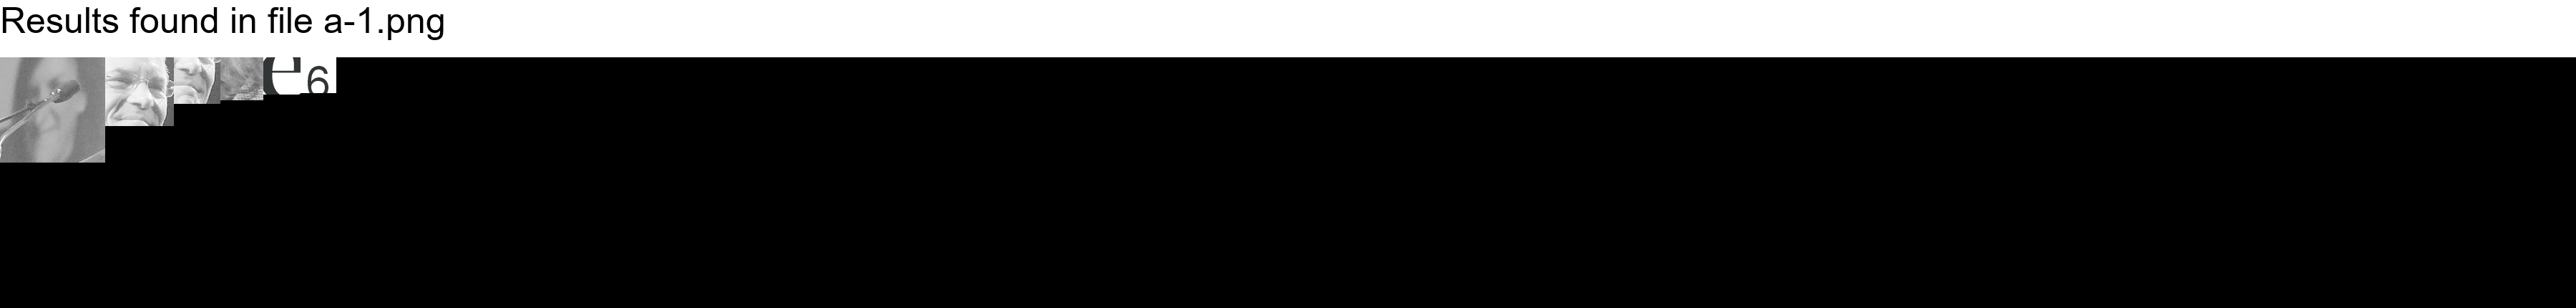

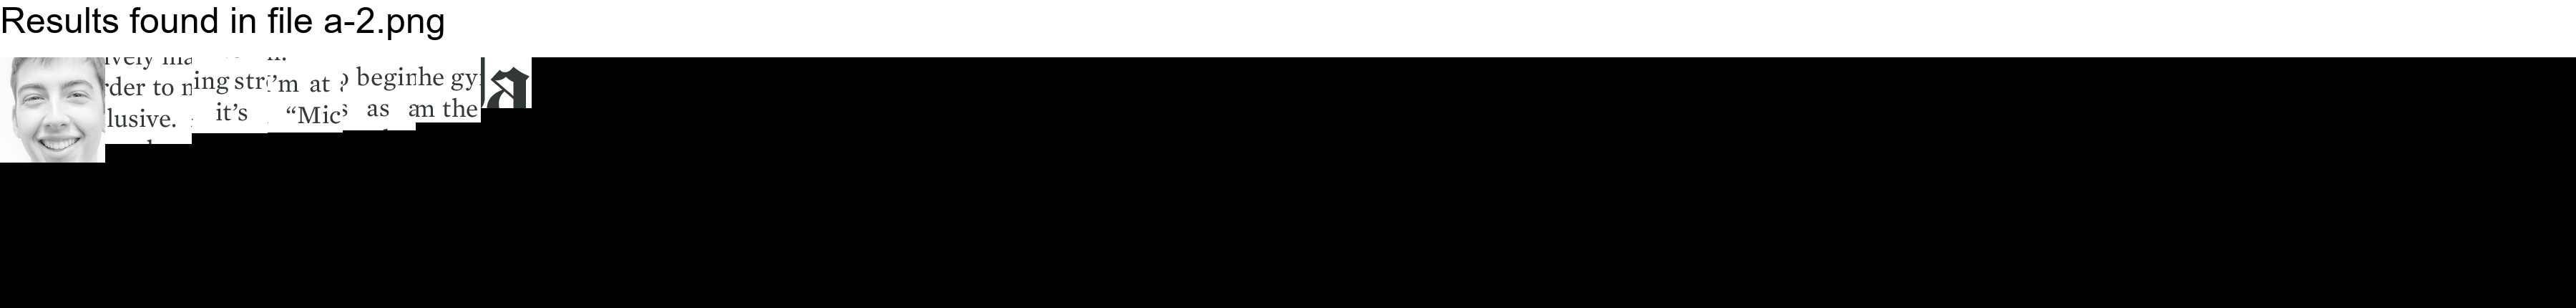

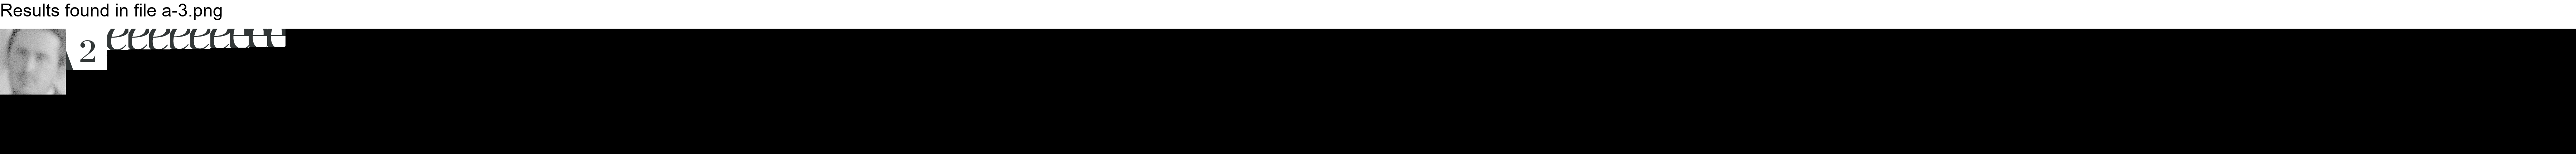

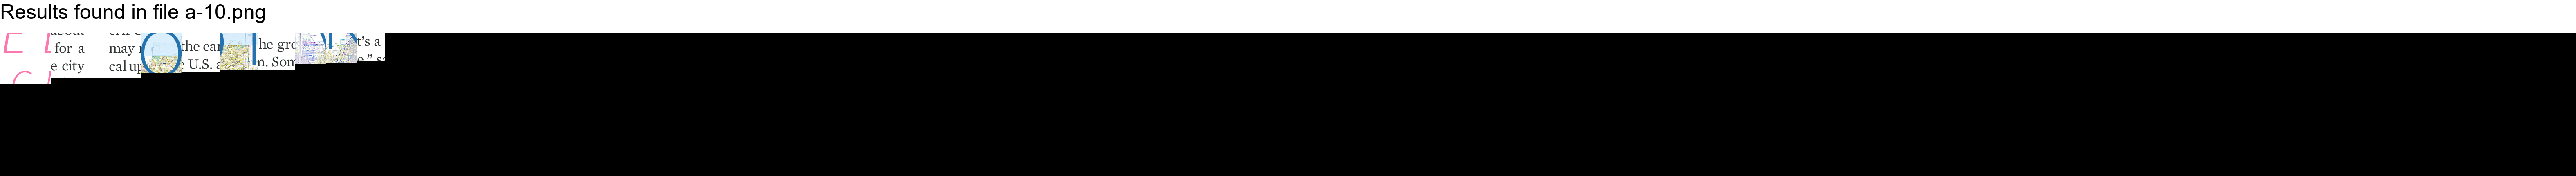

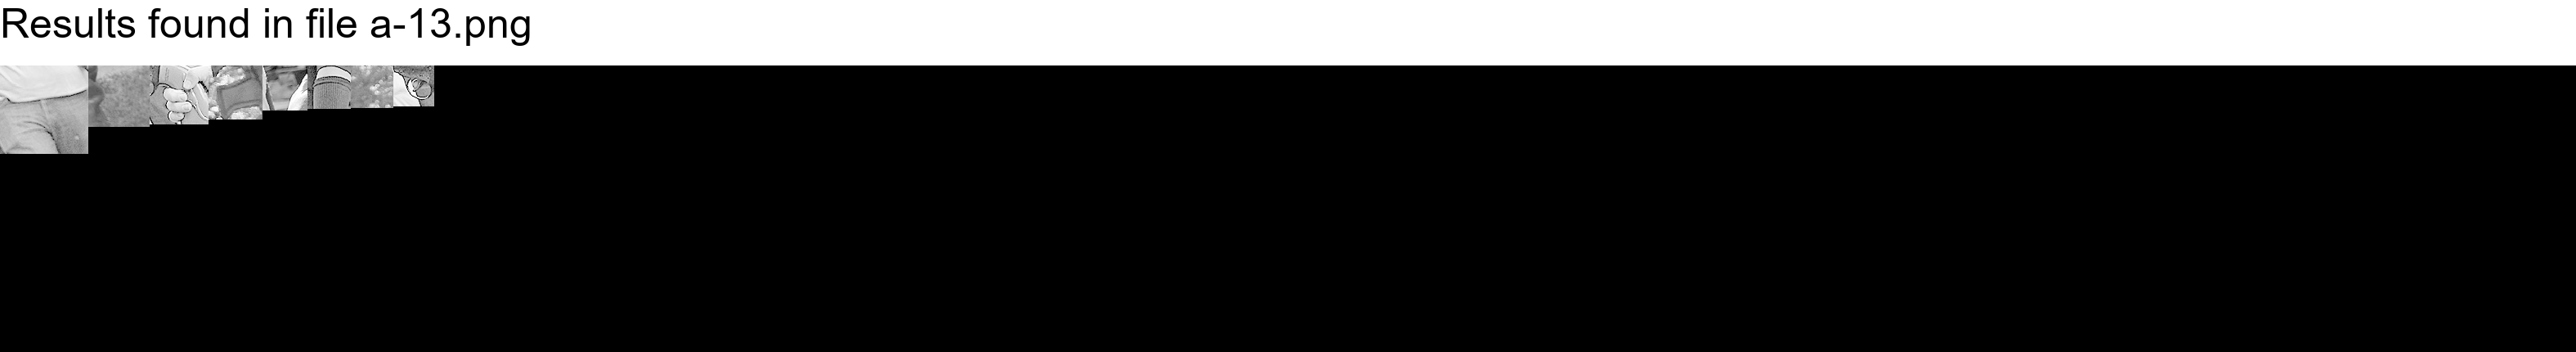

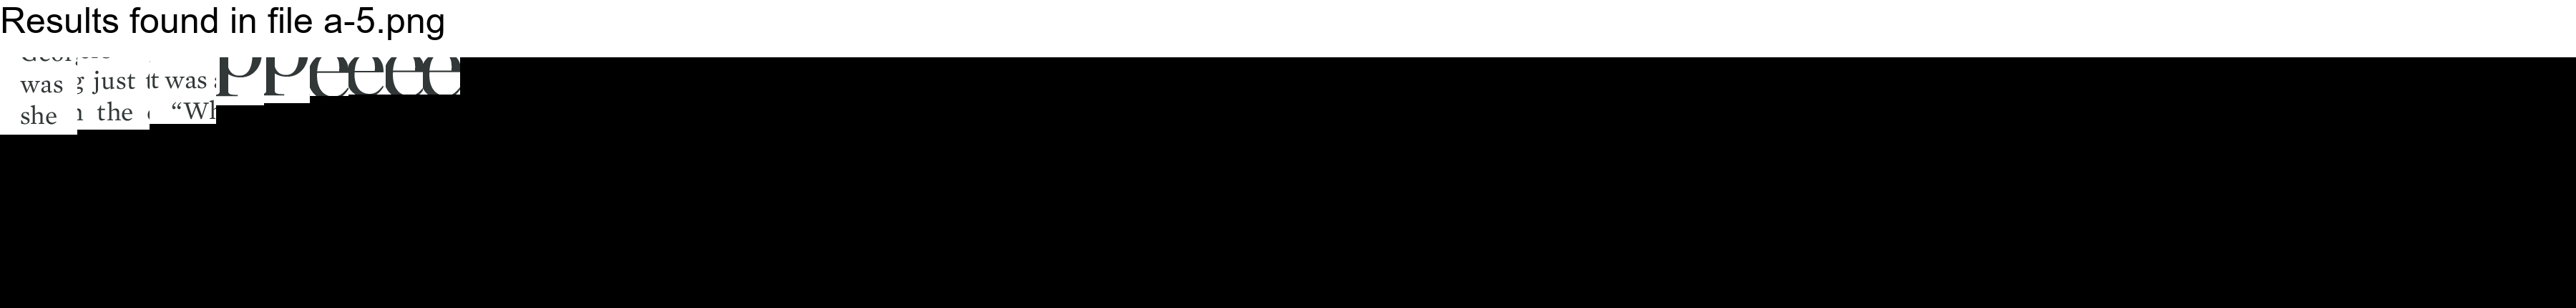

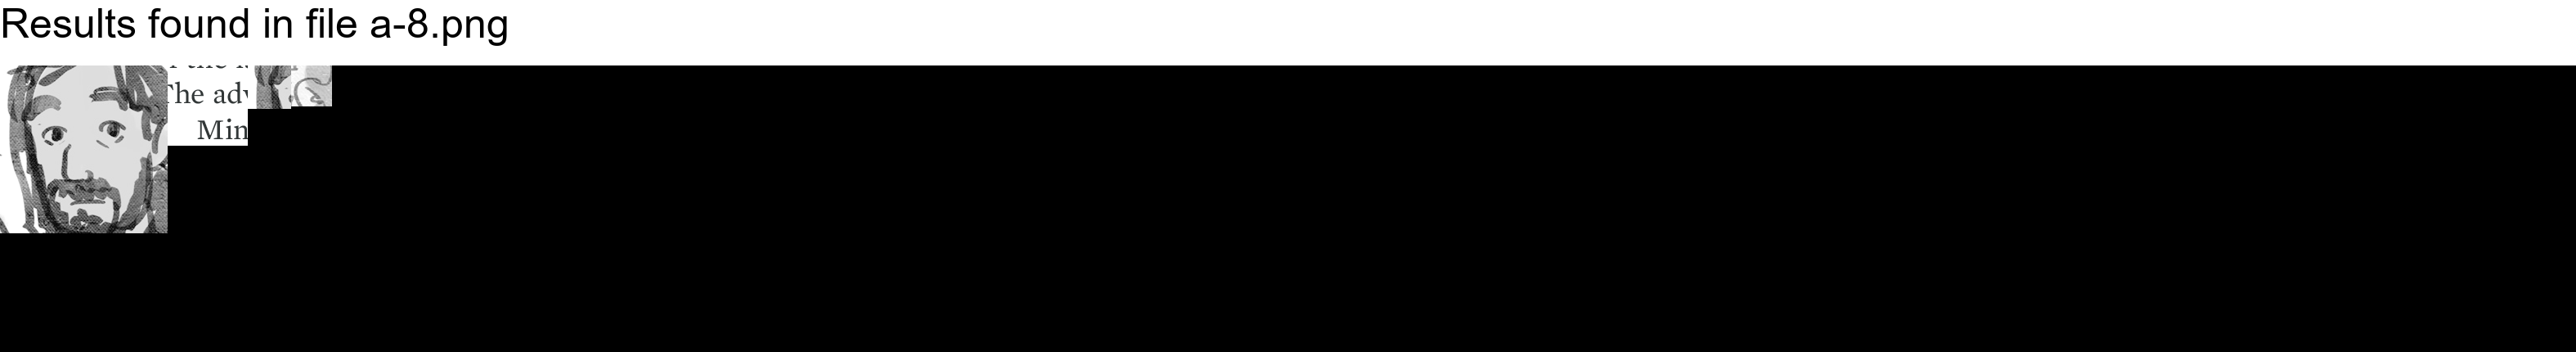

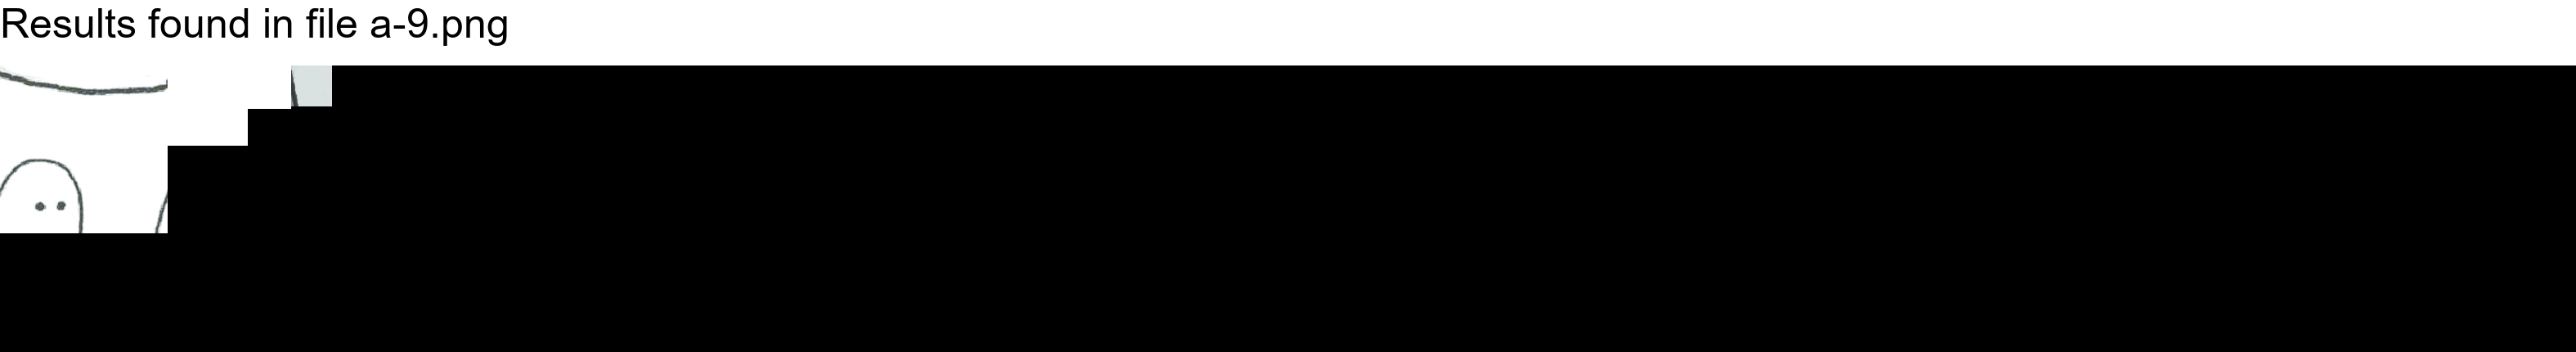

In [166]:
usr_input = 'Mark'

textRecognition(file)
manualTresh(file)

for k,v in ref_dict.items():
    if usr_input.lower() in v['text']:
        display(v['imgs'])